# Prediction of Spam 
### Jake Andersen-Lum, Stephen Hong, Yicheng Huang, Ella Ren
### STAT301: Statistical Modelling for Data Science
### March 31, 2025

In [1]:
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(broom)
library(modelr)
library(pROC)
library(rsample)
library(caret)
#install.packages("glmnet") # need this to run once before commenting out
library(glmnet)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp



Attaching package: ‘modelr’


The following object is masked from ‘package:broom’:

    bootstrap


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    l

## Introduction

As technology develops, an increasing number of users choose to use email as a method of communication. At the same time, the number of unsolicited spam emails has grown. This not only makes mailboxes cluttered and causes users to miss important emails, but it is also a burden on the ISP's system (Cranor & LaMacchia, 1998). Therefore, predicting spam is an important way to guarantee user access and maintain the integrity of the email system.

Our research question is: Can we accurately predict whether an email is spam using the variables in our [email](https://www.openintro.org/data/index.php?data=email) dataset? The primary goal of this paper is prediction, and we hope to build a model that can accurately identify spam by using these features.

## Methods and Results

#### a) Data

The dataset is called [email](https://www.openintro.org/data/index.php?data=email), which is sourced from OpenIntro, and the source is the first three months of 2012 for David Diez's Gmail Account.
The dataset contains 3921 observations and 21 variables focusing on the information of incoming emails. This is an observational data.

**Citation**: [email](https://www.openintro.org/data/index.php?data=email)

In [2]:
# Loaded the data from an open source
email <- read_csv(url("https://www.openintro.org/data/csv/email.csv"))

Rows: 3921 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (2): winner, number
dbl  (18): spam, to_multiple, from, cc, sent_email, image, attach, dollar, i...
dttm  (1): time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### Variables information

| Variable Name    | Type | Description |
|---------|-----|-------|
| spam   | Categorical  |  Indicator for whether the email was spam (1 = Yes, 0 = No).   |
| to_multiple     | Categorical  |  Indicator for whether the email was addressed to more than one recipient (1 = Yes, 0 = No).   |
| from | Categorical  |  Indicator for whether the message was listed as from anyone (1 = Yes, 0 = No).   |
| cc   | Numerical  |  The number of people cc'ed (carbon copy) in the email.  |
| sent_email     | Categorical  |  Indicator for whether the sender had been sent an email in the last 30 days (1 = Yes, 0 = No).   |
| time | Numerical  |  Time at which email was sent.   |
| image   | Numerical  |  The number of images attached in the email.   |
|   attach   | Numerical  |  The number of attached files in the email.   |
| dollar | Numerical  |  The number of times a dollar sign or the word "dollar" appeared in the email.   |
|  winner  | Categorical  |  Indicates whether "winner" appeared in the email (Yes, No).   |
|   inherit   | Numerical  |  The number of times "inherit" (or an extension, such as "inheritance") appeared in the email.   |
| viagra | Numerical  |  The number of times "viagra" appeared in the email.   |
|  password  | Numerical  |  The number of times "password" appeared in the email.   |
|   num_char   | Numerical  |  The number of characters in the email, and the unit is thousands.   |
| line_breaks | Numerical  |  The number of line breaks in the email (does not count text wrapping).   |
|  format  | Categorical  |  Indicator for whether the email was written using HTML (1 = Yes, 0 = No).   |
|   re_subj   | Categorical  |  Indicator for whether the subject started with "Re:", "RE:", "re:", or "rE:" (1 = Yes, 0 = No).  |
| exclaim_subj | Categorical  |  Indicator for whether there was an exclamation point in the subject (1 = Yes, 0 = No).   |
|  urgent_subj  | Categorical  |  Indicator for whether the word “urgent” was in the email subject (1 = Yes, 0 = No).   |
|   exclaim_mess   | Numerical  |  The number of exclamation points in the email message.   |
| number | Categorical  |  Indicates whether there was no number, a small number (under 1 million), or a big number (none, small, big).   |

#### Dropped Variables
- time: Time is removed from the dataset because emails may be sent from different time zones and cause noise.
- viagra: Viagra is taken out of the dataset due to it being a binary variable but only ever taking on one value (0). 

#### b) Exploratory Data Analysis (EDA)

In [3]:
# Selected variables and converted categorical variables to factors
email <- email |>
    select(-time, -viagra) |>
    mutate(across(c(spam, to_multiple, from, sent_email, winner, format, re_subj, exclaim_subj, urgent_subj, number), as.factor))

In [4]:
# Main developer: Jake Andersen-Lum
# Pivot to long format to get one column for variable names, and one for values
email_long <- email |>
  pivot_longer(cols = where(is.factor), names_to = "variable", values_to = "value")

# Count and calculate proportions
email_props <- email_long |>
  group_by(variable, value) |>
  summarise(n = n(), .groups = "drop") |>
  group_by(variable) |>
  mutate(prop = n / sum(n))

# Plot
bar_email <- ggplot(email_props, aes(x = variable, y = prop, fill = value)) +
                  geom_bar(stat = "identity") +
                  scale_y_continuous(labels = scales::percent) +
                  labs(title = "Proportions of Categorical Variables",
                       x = "Variable", y = "Proportion",
                       fill = "Category") +
                  theme_minimal() +
                  theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [5]:
# Main developer: Ella Ren
# Contributors: Yicheng Huang (commented)

# Compute correlation matrix for numeric variables
email_matrix <- 
   cor(email[, sapply(email, is.numeric)], ) %>%
   as_tibble(rownames = 'v1') %>%
   pivot_longer(-v1, names_to = "v2", values_to = "corr")

# Create a heatmap of the correlations
heatmap_email <- 
  email_matrix %>%
  ggplot(aes(x = v1, y = v2)) +
  geom_tile(aes(fill = corr), color = "white") +
  scale_fill_distiller("Correlation \n",
      palette =  "RdBu",
      direction = 1, 
      limits = c(-1, 1)
    ) +
    labs(x = "", y = "", title = "Heatmap for Numerical and Binary Variables") +
    theme_minimal() +
    theme(
        axis.text.x = element_text(angle = 45, vjust = 1, size = 13, hjust = 1),
        axis.text.y = element_text(vjust = 1, size = 13, hjust = 1),
        legend.title = element_text(size = 13),
        legend.text = element_text(size = 11),
        legend.key.size = unit(1.3, "cm")
    ) +
    coord_fixed() +
   geom_text(aes(x = v1, y = v2, label = round(corr, 2)), color = "black", size = 3)

In [6]:
# Main developer: Jake Andersen-Lum
# Contributors: Yicheng Huang (formatted & commented)

# Convert "format" and "has_attach" into labeled categories
email_scatter = email |> 
    mutate(format = factor(format, labels = c("Plain Text", "HTML")),
           has_attach = if_else(attach > 0, "Yes", "No"))

# Create the scatterplot which facets by format and has_attach
scatterplot_email = ggplot(email_scatter, aes(num_char, y = dollar + password, color = spam)) +
    geom_point(alpha = 0.2, size = 2.5) +
    facet_grid(format ~ has_attach, labeller = labeller(has_attach = c("No" = "No Attachment", "Yes" = "Has Attachment"))) +
    scale_x_continuous(name = "Number of Characters (thousands)") +
    scale_y_continuous(name = "Sum of Spam-related Keywords (dollar, password)") +
    labs(title = "Exploring Email Spam: Keyword Counts Vs. Email Length",
         color = "Spam Status")

In [7]:
heatmap_email
scatterplot_email
bar_email

A potential problem coming from the heatmap is that there are certain variables with high correlation such as num_char + line_breaks and image + attach. These high correlation values could indicate a violation of multicollinearity when using such variables in a regression model. The scatterplots indicate the possibility of outliers in our data, especially in the bottom left plot as there are some extreme values regarding the sum of spam-related keywords, which could bias our outcomes and conclusions. However, after applying many different transformations to variables in the graph, there was no significant distinction from before, thus we chose to leave the variables as they are originally. 

The looking at the bar graph, from and urgent_subj all seem to only have one response. To further investigate, we found the number of rows corresponding to when from is equal to zero and the number of rows for when urgent_subj equals to 1. We saw that there are only three rows for when from is equal to one, therefore we chose to also get rid of that variable. urgent_subj equalling to one had a couple more rows, therefore we decided to keep it to see if LASSO eliminates it. 

No missing values were present for our dataset.

#### c) Methods: Plan

#### Data Splitting and Model Choice

Since we are creating a predictive model, we need to split the dataset into testing and training data to evaluate the model's performance. We will be creating a logistic regression model with the training data because our response variable (spam) is binary.

In [8]:
set.seed(3)
# All group members developed this code together with the guidance of tutorial 10

# Split the data into training and testing sets (70% training, 30% testing)
email_split <- initial_split(email, prop = 0.7, strata = spam)
email_training <- training(email_split)
email_testing <- testing(email_split)

#### Variable Selection

There are many approaches we could take to estimate the model. Our group chose to implement LASSO as it is the method we were most familiar with. Using LASSO, we were able to select a subset of covariates for our model through the use of our training data. 

In [9]:
# All group members developed this code together with the guidance of tutorial 10
# Create model and response matrix for both training and testing sets 
matrix_X_train <- model.matrix(object = spam ~ ., data = email_training)[,-1]
matrix_Y_train <- as.matrix(email_training$spam, ncol = 1)

matrix_X_test <- model.matrix(object = spam ~ ., data = email_testing)[, -1]
# Do we ever use this one?
# matrix_Y_test <- as.matrix(email_testing$spam, ncol = 1)

In the above block, we turned the training and testing datasets into a design matrix for all covariates, excluding the first column of intercepts. The response (spam) is also turned into a matrix for the training set, this allows consistency of types when using LASSO.

In [10]:
set.seed(4)

# All group members developed this code together with the guidance of tutorial 10
# Finds lambda that produces the highest average AUC when LASSO penalty is used
email_cv_lambda_LASSO <- cv.glmnet(
    x = matrix_X_train, y = matrix_Y_train,
    alpha = 1,
    family = "binomial",
    type.measure = "auc",
    nfolds = 5
    )

In [23]:
print("Figure 1: LASSO Feature Selection")
coef(email_cv_lambda_LASSO, s = "lambda.min")

[1] "Figure 1: LASSO Feature Selection"


20 x 1 sparse Matrix of class "dgCMatrix"
                        s1
(Intercept)    3.379245808
to_multiple1  -2.162991854
from1         -3.681219680
cc             0.026521627
sent_email1   -4.603474852
image         -1.175527887
attach         0.466449650
dollar        -0.065684682
winneryes      1.907664704
inherit        0.291779771
password      -0.612637760
num_char       .          
line_breaks   -0.002690473
format1       -0.621938530
re_subj1      -1.791911771
exclaim_subj1  .          
urgent_subj1   3.560834294
exclaim_mess   0.008273503
numbernone     0.160881784
numbersmall   -0.889199812

We used 5-fold cross-validation on our training data to fit logistic models. Additionally, it calculates the AUC, which evaluates how well the model is able to distinguish between the binary response. Through LASSO we selected all variables except num_char and exclaim_subj and end up fitting a logistic regression model using the training data without these variables.

In [12]:
chosen_model = glm(spam ~.-num_char-exclaim_subj-from, family = "binomial", data = email)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


In [13]:
# main developer: Jake Andersen-Lum

# ROC for the chosen model 
roc_glm_new <- roc(
  response = email_testing$spam,
  predictor = predict(chosen_model,
                      newdata = email_testing,
                      type = "response"))

roc_glm_new$auc

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.9062

We create ROC curve using the test data got from splitting our original data and get a AUC score of 0.906, this indicates decent performance of our model.

In [24]:
# Main developer: Stephen Hong
# code adapted from worksheet 10
email_pred_class <- 
  round(predict(chosen_model, email_testing, type = "response"), 0)

email_confusion_matrix <- 
    confusionMatrix(
    data = as.factor(email_pred_class),
    reference = as.factor(email_testing$spam),
    positive = "1"
)

# store confusion matrix metrics in a table
conf_mat_stats <- tibble(Sensitivity = c(email_confusion_matrix$byClass["Sensitivity"]),
                         Specificity = c(email_confusion_matrix$byClass["Specificity"]),
                         Precision = c(email_confusion_matrix$byClass["Precision"]),
                         Accuracy = c(email_confusion_matrix$overall["Accuracy"]),
                         Kappa = c(email_confusion_matrix$overall["Kappa"]))

print("Table 2: Metrics of 0.5 threshold")
conf_mat_stats   

[1] "Table 2: Metrics of 0.5 threshold"


Sensitivity,Specificity,Precision,Accuracy,Kappa
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.1372549,0.9972093,0.8235294,0.9226848,0.2158791


We used a confusion matrix to interpret metric of our model. The trained model has a high accuracy when predicting on the test data, which is expected, but is not a good metric for this model's evaluation due to a large class imbalance with more non-spam emails in the dataset. We can see this through the very high specificity metric, as most of the emails in our dataset are not spam. A metric like precision is more valuable for evaluating the model's performance, as this metric tells us how many of the emails that the model classified as spam are actually spam emails. The precision of our model is decent, though the recall/sensitivity is low, which indicates that the model often classifies spam emails as non-spam. 

With the sensitivity being quite low, this indicates that the model is not very good at predicting when an email is spam. To try and counter this, we changed the threshold value. To determine that to change the threshold to, we looked at the ROC curve approach. 

Setting levels: control = 0, case = 1

Setting direction: controls < cases



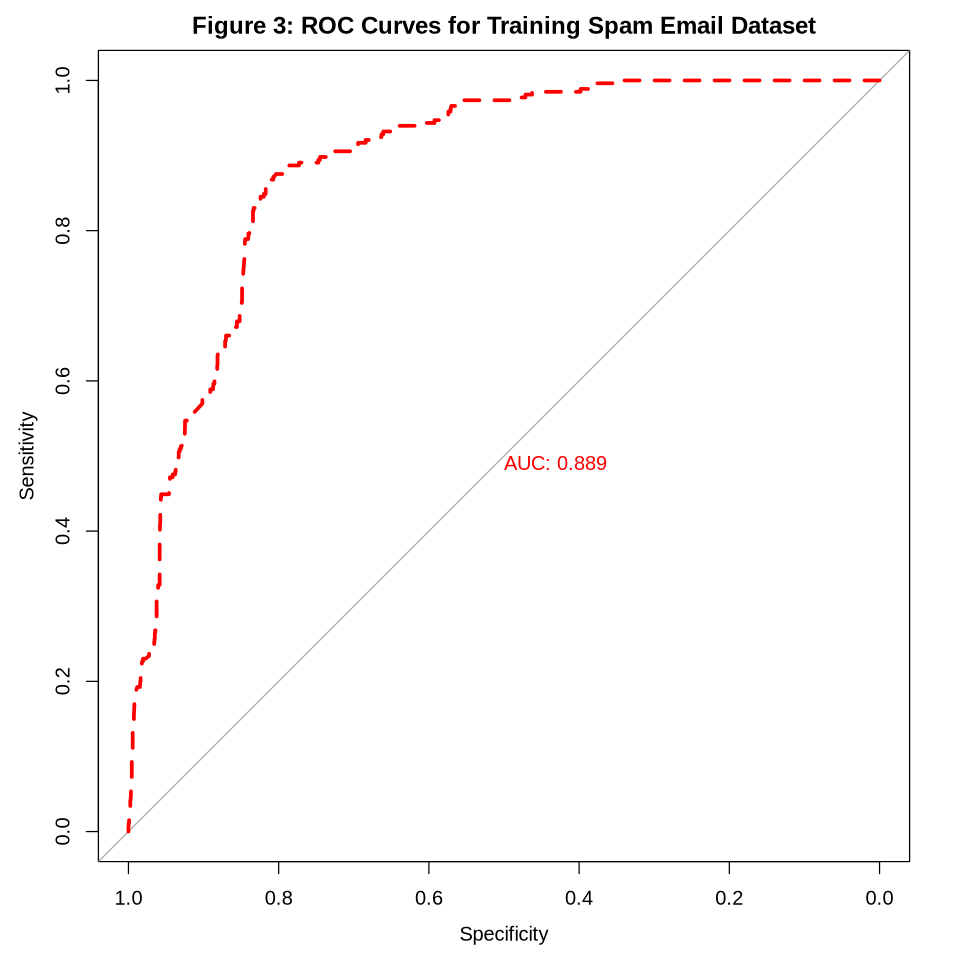

In [25]:
# main developer: Jake Andersen-Lum

# Predict on training set
train_probs <- predict(chosen_model, newdata = email_training, type = "response")

# ROC on training set
roc_train <- roc(response = email_training$spam, predictor = train_probs)

# Find threshold (on training set only)
coords_train <- coords(roc_train, x = "best", best.method = "closest.topleft", transpose = FALSE)
best_thresh <- coords_train$threshold

plot(roc_train, print.auc = TRUE, col = "red", lwd = 3, lty = 2, main = "Figure 3: ROC Curves for Training Spam Email Dataset")

Since our previous ROC curve used the testing set, we could not use that curve to find an appropriate threshold as it would be peeking at the testing data. Instead, a new ROC curve was created on the training set and the best decision threshold is the value closest to the top left corner. 

In [27]:
options(repr.plot.width = 8, repr.plot.height = 8)
# Main developer: Stephen Hong + Jake Andersen-Lum

# Predicted probabilities
pred_probs_glm <- predict(chosen_model, newdata = email_testing, type = "response")

# Define both thresholds
thresholds <- c(best_thresh, 0.5)
threshold_labels <- c("Custom Threshold Using ROC Curve", "Default 0.5")

# Initialize empty list to collect results
conf_mat_stats_list <- list()

# Loop through both thresholds
for (i in 1:2) {
  threshold <- thresholds[i]
  label <- threshold_labels[i]
  
  # Apply threshold
  email_pred_class <- ifelse(pred_probs_glm > threshold, 1, 0)

  # Compute confusion matrix
  cm <- confusionMatrix(
    data = as.factor(email_pred_class),
    reference = as.factor(email_testing$spam),
    positive = "1"
  )
  
  # Store results in a tibble
precision <- cm$byClass["Precision"]
recall    <- cm$byClass["Recall"]
f1_score  <- 2 * precision * recall / (precision + recall)

  conf_mat_stats_list[[i]] <- tibble(
    Threshold = label,
    Sensitivity = cm$byClass["Sensitivity"],
    Specificity = cm$byClass["Specificity"],
    Precision   = precision,
    Recall      = recall,
    Accuracy    = cm$overall["Accuracy"],
    Kappa       = cm$overall["Kappa"],
    F1          = f1_score
  )
}

# Combine both rows into one table
conf_mat_stats_compare <- bind_rows(conf_mat_stats_list)

# Show result
#
conf_mat_stats_compare

Threshold,Sensitivity,Specificity,Precision,Recall,Accuracy,Kappa,F1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Custom Threshold Using ROC Curve,0.8529412,0.8288372,0.3210332,0.8529412,0.8309261,0.3896262,0.4664879
Default 0.5,0.1372549,0.9972093,0.8235294,0.1372549,0.9226848,0.2158791,0.2352941


We then found the metrics according to the new threshold using the same technique as before and binded it to our original threshold of 0.5. We see that with this new threshold, our sensitivity has increased a lot, but at the cost of precision. 

## Discussion
In conclusion, our original data was quite poor at predicting spam correctly due to the imbalance in spam/non-spam classification in the original dataset. However, by adjusting the threshold a little by the ROC curve, we were able to make our model better at predicting true spam. 

One way our model could be improved by looking more into the possibility of interaction between terms, as the addition of interaction could drastically change how well our model predicts spam.

In the future, we could look at other thresholds, whether that be calculating it using another method (i.e PR curves) or simply manually picking custom threshold values. Additionally, researching more into the method used by large companies to classify spam email, like Google or Microsoft would be an interesting topic. 

## References
Cranor, L. F., & LaMacchia, B. A. (1998). Spam! *Communications of the ACM, 41*(8), 74–83. https://doi.org/10.1145/280324.280336 